# Calculate Z-scores for players

This takes the list of players that we're trying to calculate scores for, and creates z-scores for players with an arbitrarily chosen minimum innings (for pitchers) or plate appearances (for hitters).

Notes for this year's sheet:

- Z-score avg/stdev calculated using minimum IP (70) or PA (35) stats for batting and pitching.
- Reliever value was artificially decremented as usual since they're normally over-inflated value-wise. Multiplied by (project innings) / (90th pctile of projected innings), capped at 1.0.

In [1]:
import pandas as pd
import numpy as np
import os
import sqlalchemy
import psycopg2
import seaborn as sb
import requests

# arbitrarily high max view columns
pd.options.display.max_columns = 150
pd.options.display.max_rows = 200

/Users/zach/Library/Python/3.7/lib/python/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


## SqlAlchemy Connection Information

These are used to get and return a connection to the postgres DB so that we can query for player stats and write them back to the table.

In [2]:
# connection information for the database
POSTGRES_USER = os.environ.get("POSTGRES_USER")
POSTGRES_PASSWORD = os.environ.get("POSTGRES_PASSWORD")
POSTGRES_IP = "192.168.0.118"
POSTGRES_PORT = 5432
POSTGRES_DB = "postgres"

def get_sqlalchemy_engine():
    """
    Create and return a SQLAlchemy engine for inserting into postgres.
    """
    # ## Write Information Back to Database
    #
    return sqlalchemy.create_engine(
        "postgres://{user}:{password}@{host}:{port}/{db}".format(
            user=POSTGRES_USER,
            password=POSTGRES_PASSWORD,
            host=POSTGRES_IP,
            port=POSTGRES_PORT,
            db=POSTGRES_DB,
        )
    )

In [17]:
# create a connection and read in pitchers data
engine = get_sqlalchemy_engine()
conn = engine.connect()

## Calculate Z-Scores

For each of the players, we calculate a z-score based on how they compare to the rest of the league. There are several columns that we want to do this for.

- For each z-score, there is an arbitrary minimum set to inflate the league average away from non-full-time players.
- After each is totaled, the z-scores are totaled and then z-scored again to make a single number. This is done so that we can compare pitchers and batters into the same chart.

In [50]:
# read in information from postgres
dfp = pd.read_sql("select * from fantasy.pitchers_projections_depth_charts where ip > 0.0", conn)
dfb = pd.read_sql("select * from fantasy.batters_projections_depth_charts where pa > 50", conn)

In [60]:
# create any calculated columns necessary
dfb['k_pct'] = dfb['so'] / dfb['ab']
dfb['rc'] = dfb['ab'] * dfb['obp'] * dfb['slg']

# quality starts metric from here:
# https://yourfantasyjoe.blogspot.com/2010/02/projecting-quality-starts.html
# xQS = GS * (.4650115 - (ERA * .0872381) + ((IP/GS) * .0746775))
dfp['qs'] = dfp['gs'] * (0.4650115 - (dfp['era'] * 0.0872381) + ((dfp['ip']/dfp['gs']) * .0746775))
dfp.fillna(value={'qs': 0.0}, inplace=True)
print()

In [88]:
# thresholds for batters and pitchers
MINIMUM_INNINGS_PITCHED = 100
MINIMUM_PLATE_APPEARANCES = 400
min_pa = dfb['pa'] > MINIMUM_PLATE_APPEARANCES
min_ip = dfp['ip'] > MINIMUM_INNINGS_PITCHED

# dict of columns that we want to calculate z-scores for
# +1 means more is better, -1 means negative is better
dfb_score_cols = {
    "pa": {"dir": 1, "weight": 1.3}, 
    "k_pct": {"dir": -1, "weight": 1.0},
    "hr": {"dir": 1, "weight": 0.9},
    "rc": {"dir": 1, "weight": 1.4},
    "woba": {"dir": 1, "weight": 1.3},
    "slg": {"dir": 1, "weight": 1.0},
    "adp": {"dir": -1, "weight": 0.5}
}
dfp_score_cols = {
    "ip": {"dir": 1, "weight": 1.3},
    "era": {"dir": -1, "weight": 1.0},
    "hr": {"dir": -1, "weight": 0.9},
    "so": {"dir": 1, "weight": 1.0},
    "whip": {"dir": -1, "weight": 1.5},
    "k-9": {"dir": 1, "weight": 1.3},
    "qs": {"dir": 1, "weight": 1.0},
    "gs": {"dir": 1, "weight": 0.35}
}
dfb_weight = 1.0
dfp_weight = 0.88

# get all of the score columns for maximum z-scoring
dfb_score_col_names = [x + "_score" for x in dfb_score_cols.keys()]
dfp_score_col_names = [x + "_score" for x in dfp_score_cols.keys()]

In [89]:
# only mean and stdev are filtered by minimums, so that way the player's actual
# projections are still counted normally.

for col in dfb_score_cols.keys():
    col_score = col + "_score"
    dfb[col_score] = (
        (dfb[col] - dfb[col][min_pa].mean()) / dfb[col][min_pa].std(ddof=0)
        * dfb_score_cols[col]["dir"]
        * dfb_score_cols[col]["weight"]
    )

for col in dfp_score_cols.keys():
    col_score = col + "_score"
    dfp[col_score] = (
        (dfp[col] - dfp[col][min_ip].mean()) / dfp[col][min_ip].std(ddof=0)
        * dfp_score_cols[col]["dir"]
        * dfp_score_cols[col]["weight"]
    )

In [90]:
# sum all of the values into 'total_score'
dfb['total_score'] = dfb[dfb_score_col_names].sum(axis=1)
dfb['total_z_score'] = (
    dfb['total_score'] - dfb['total_score'][min_pa].mean()) / dfb['total_score'][min_pa].std(ddof=0)
dfb['total_z_score_rank'] = dfb['total_z_score'].rank(ascending=False)

dfp['total_score'] = dfp[dfp_score_col_names].sum(axis=1)
dfp['total_z_score'] = (
    dfp['total_score'] - dfp['total_score'][min_ip].mean()) / dfp['total_score'][min_ip].std(ddof=0)
dfp['total_z_score_rank'] = dfp['total_z_score'].rank(ascending=False)

# sort by score descending
dfb.sort_values(by='total_z_score_rank', inplace=True)
dfp.sort_values(by='total_z_score_rank', inplace=True)


### Inflate League Mean

For the majority of the z-scores that we're taking, the actual values of them are affected by the long-tail of players who don't get much playing time. To offset this, the mean is artifically placed at halfway through our number of drafted players to account for the fact that will be replacement level for our league.

In [91]:
# decrement scores by the mean of all drafted positions
NUM_TEAMS = 8
NUM_BATTERS = 15
NUM_PITCHERS = 10

MIDDLE_BATTER_INDEX = (NUM_TEAMS * NUM_BATTERS) / 2
MIDDLE_PITCHER_INDEX = (NUM_TEAMS * NUM_PITCHERS) / 2

In [92]:
middle_batter_score = dfb[dfb['total_z_score_rank'] == MIDDLE_BATTER_INDEX]['total_z_score']
dfb['total_z_score'] = dfb['total_z_score'] - float(middle_batter_score)
dfb['total_z_score'] *= dfb_weight

middle_pitcher_score = dfp[dfp['total_z_score_rank'] == MIDDLE_PITCHER_INDEX]['total_z_score']
dfp['total_z_score'] = dfp['total_z_score'] - float(middle_pitcher_score)


# apply weights by how far above zero the player is (capped at zero for negatives)
max_score = float(dfp['total_z_score'].max())
dfp['weight_diff'] = dfp['total_z_score'].apply(lambda x: max(0.0, x / max_score))
dfp['weight_scale'] = dfp['weight_diff'].apply(lambda x: dfp_weight + ((1 - x) * (1 - dfp_weight)))
dfp['total_z_score'] = dfp['total_z_score'] * dfp['weight_scale']

## Top Batter Results

In [57]:
dfb.head(50)

,index,name,g,pa,ab,h,2b,3b,hr,r,rbi,bb,so,hbp,sb,cs,avg,obp,slg,ops,woba,fld,bsr,war,adp,k_pct,rc,pa_score,k_pct_score,hr_score,rc_score,woba_score,slg_score,adp_score,total_score,total_z_score,total_z_score_rank
0,0,Mike Trout,157,658,517,153,28,4,40,114,101,124,135,10,23,6,0.295,0.437,0.595,1.032,0.427,0.4,3.6,9.2,1.1,0.261122,134.427755,1.519772,-0.287730,2.297863,4.713972,4.859839,3.262436,0.666996,17.033149,2.252111,1.0
4,4,Mookie Betts,162,679,591,178,43,4,29,115,95,76,92,5,27,7,0.301,0.382,0.532,0.913,0.386,16.9,5.3,7.4,1.9,0.155668,120.105384,1.890399,1.382255,1.073991,3.602870,2.837132,1.986617,0.664923,13.438186,1.623633,2.0
3,3,J.D. Martinez,155,651,576,169,35,2,39,98,117,66,163,4,4,2,0.293,0.366,0.565,0.931,0.389,-0.1,-1.8,4.0,6.1,0.282986,119.111040,1.396230,-0.633977,2.186602,3.525731,2.985135,2.654903,0.654043,12.768666,1.506586,3.0
10,10,Nolan Arenado,155,651,578,166,38,4,36,97,112,62,114,3,3,2,0.287,0.357,0.550,0.907,0.379,7.0,-0.5,4.9,7.1,0.197232,113.490300,1.396230,0.724046,1.852819,3.089684,2.491791,2.351136,0.651452,12.557159,1.469610,4.0
1,1,Juan Soto,152,637,539,158,30,3,32,98,101,92,122,2,7,3,0.294,0.397,0.538,0.935,0.395,-4.7,0.4,4.7,35.3,0.226345,115.122854,1.149146,0.263002,1.407775,3.216335,3.281141,2.108123,0.578395,12.003916,1.372891,5.0
8,8,Jose Ramirez,155,651,562,162,41,4,28,100,94,77,74,5,25,8,0.289,0.377,0.522,0.899,0.380,3.8,3.7,6.3,4.2,0.131673,110.598228,1.396230,1.762257,0.962730,2.865323,2.541126,1.784105,0.658965,11.970736,1.367090,6.0
12,12,Anthony Rizzo,155,651,548,153,33,2,28,88,98,78,89,19,8,4,0.279,0.384,0.501,0.885,0.375,4.9,-1.4,4.3,37.7,0.162409,105.426432,1.396230,1.275512,0.962730,2.464105,2.294454,1.358832,0.572177,10.324041,1.079212,7.0
5,5,Christian Yelich,155,651,567,169,35,4,27,98,94,72,136,6,17,5,0.297,0.380,0.519,0.898,0.383,2.3,2.7,5.2,6.8,0.239859,111.823740,1.396230,0.048994,0.851469,2.960396,2.689129,1.723352,0.652229,10.321800,1.078820,8.0
2,2,Bryce Harper,148,623,500,133,27,1,35,97,100,112,147,4,12,5,0.266,0.401,0.533,0.934,0.392,-3.5,0.8,4.8,16.9,0.294000,106.866500,0.902062,-0.808396,1.741558,2.575823,3.133138,2.006868,0.626063,10.177115,1.053526,9.0
9,9,Freddie Freeman,157,658,565,165,39,3,27,91,93,80,132,8,8,3,0.292,0.384,0.513,0.897,0.379,5.2,0.4,4.6,21.6,0.233628,111.300480,1.519772,0.147663,0.851469,2.919802,2.491791,1.601846,0.613887,10.146231,1.048127,10.0


## Top Pitcher Results

In [93]:
## Top Pitchers
dfp.head(100)

,index,name,w,l,sv,hld,era,gs,g,ip,h,er,hr,so,bb,whip,k-9,bb-9,fip,war,qs,ip_score,era_score,hr_score,so_score,whip_score,k-9_score,qs_score,gs_score,total_score,total_z_score,total_z_score_rank,weight_diff,weight_scale
1,1,Chris Sale,15,6,0,0,2.70,29,29,183.0,141,55,18,238,38,0.97,11.67,1.85,2.63,6.0,20.320573,1.411794,2.815424,0.590364,2.496776,4.884286,3.582885,1.941941,0.229778,17.953247,1.978050,1.0,1.000000,0.880000
14,14,Max Scherzer,16,8,0,0,3.06,32,32,210.0,162,71,25,271,54,1.03,11.61,2.32,3.04,5.7,22.020288,2.736270,2.149518,-0.925241,3.348126,4.039903,3.521524,2.474422,0.466391,17.810913,1.960835,2.0,0.989939,0.881207
5,5,Jacob deGrom,14,9,0,0,2.84,32,32,211.0,174,67,20,249,50,1.06,10.59,2.14,2.82,6.0,22.709122,2.785325,2.556460,0.157334,2.780559,3.617711,2.478382,2.690218,0.466391,17.532381,1.926988,3.0,0.970249,0.883570
25,27,Justin Verlander,16,8,0,0,3.20,32,32,204.0,164,72,26,243,49,1.04,10.73,2.18,3.27,5.2,21.181397,2.441942,1.890555,-1.141756,2.625768,3.899172,2.621558,2.211617,0.466391,15.015248,1.611626,4.0,0.792316,0.904922
20,22,Corey Kluber,16,9,0,0,3.27,32,32,211.0,187,77,23,220,43,1.09,9.37,1.82,3.22,5.3,21.508726,2.785325,1.761073,-0.492211,2.032404,3.195520,1.230703,2.314162,0.466391,13.293366,1.386060,5.0,0.670598,0.919528
23,25,Gerrit Cole,14,8,0,0,3.35,32,32,198.0,167,73,22,231,57,1.14,10.51,2.61,3.25,4.8,20.314589,2.147614,1.613094,-0.275696,2.316187,2.491868,2.396567,1.940066,0.466391,13.096091,1.359707,6.0,0.656653,0.921202
32,34,Blake Snell,15,10,0,0,3.15,32,32,190.0,153,66,18,224,75,1.20,10.63,3.55,3.30,4.0,20.275493,1.755177,1.983042,0.590364,2.135597,1.647485,2.519289,1.927818,0.466391,13.025163,1.350206,7.0,0.651639,0.921803
38,40,Carlos Carrasco,15,9,0,0,3.41,32,32,194.0,175,73,23,212,45,1.13,9.83,2.08,3.33,4.5,19.848382,1.951395,1.502110,-0.492211,1.826016,2.632598,1.701139,1.794014,0.466391,11.381453,1.126236,8.0,0.535447,0.935746
53,55,Trevor Bauer,14,9,0,0,3.47,32,32,191.0,166,74,20,215,67,1.22,10.09,3.15,3.42,4.3,19.456852,1.804231,1.391126,0.157334,1.903411,1.366024,1.967038,1.671357,0.466391,10.726912,1.035022,9.0,0.489179,0.941299
44,46,Aaron Nola,13,9,0,0,3.39,31,31,189.0,170,71,20,200,51,1.17,9.49,2.44,3.36,4.2,19.361552,1.706122,1.539105,0.157334,1.516434,2.069676,1.353425,1.641502,0.387520,10.371118,0.984955,10.0,0.464028,0.944317


## Write to the Database

Prior to writing the excel files, write back to the database for safekeeping.

In [94]:
dfb.to_sql("batters_scores", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.batters_scores to public")
dfp.to_sql("pitchers_scores", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.pitchers_scores to public")

## Grab Mr. Cheatsheet Data

This is another take on the same thing, so it's a good comparison point. 

The mr cheatsheet projections come from this google sheet: [Mr Cheatsheet Special Blend Projections 2019](https://docs.google.com/spreadsheets/d/1Lr4ZdIlFyHghnD6QuaVQ8cp6Q1vw7khC3Nfw71bHO9E/edit#gid=973893717)

In [133]:
dfp_ch = pd.read_csv("mr_cheatsheet_pitchers_2019.csv")
dfb_ch = pd.read_csv("mr_cheatsheet_batters_2019.csv")

# list of name mismatches between ESPN and MCC
name_mismatches = {
    'Ronald Acuna': 'Ronald Acuna Jr.',
    'Nick Castellanos': 'Nicholas Castellanos',
    'Vincent Velasquez': 'Vince Velasquez',
    'Yulieski Gurriel': 'Yuli Gurriel',
    'Jacob Lamb': 'Jake Lamb',
    'Jung-Ho Kang': 'Jung Ho Kang',
    'Matt Boyd': 'Matthew Boyd',
    'Steven Souza': 'Steven Souza Jr.'
}

for df in (dfp_ch, dfb_ch):
    df.columns = [x.lower().replace(" ", "_").replace("-", "_") for x in df.columns]
    df['player'] = df['player'].apply(lambda x: name_mismatches.get(x, x)).head(150)

# lower all the column names
dfp_ch.to_sql("pitchers_mrcheatsheet", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.pitchers_mrcheatsheet to public")
dfb_ch.to_sql("batters_mrcheatsheet", conn, schema="fantasy", if_exists="replace")
result = conn.execute("grant select on fantasy.batters_mrcheatsheet to public")

## Create Draft Sheet

This sheet includes a number of important pieces of information for drafting specifically, so that players can look up by eligibility as well as important stats.

- Name
- Eligibility
- Positions
- Combined scores

In [134]:
draft_sheet_query = """
select
    p.fullname,
    p.eligibility,
    p.position as pos,
    p.injurystatus,
    upper(sc.catg) as catg,
    p.averagedraftposition as espn_adp,
    p.auctionvalue as espn_auctionvalue,
    sc.score,
    mcc.mcc_werth
from fantasy.players p
    left join (
        select name, 'b' as catg, total_z_score as score
        from fantasy.batters_scores
        union all
        select name, 'p' as catg, total_z_score as score
        from fantasy.pitchers_scores
    ) sc
        on p.fullname = sc.name
        and case when position like '%P%' then 'p' else 'b' end = sc.catg
    left join (
        select player as name, 'b' as catg, werth_roto_value as mcc_werth
        from fantasy.batters_mrcheatsheet
        union all
        select player as name, 'p' as catg, werth_roto_value as mcc_werth
        from fantasy.pitchers_mrcheatsheet
    ) mcc
        on p.fullname = mcc.name
        and case when position like '%P%' then 'p' else 'b' end = mcc.catg
"""
dfd = pd.read_sql(sqlalchemy.text(draft_sheet_query), conn)

In [137]:
dfd.sort_values(by='score', inplace=True, ascending=False)
dfd['rank'] = dfd['score'].rank(ascending=False, method='first', na_option='bottom')
dfd.reset_index(drop=True)
print()

## Create Positional Scarcity Metrics

Players are grouped into the _most scarce_ position that they're eligible for. Scarcity is defined as number of players above replacement value. This creates a map of all positions and the number of players above replacement, and then uses that to group players to which they should be in.

In [138]:
# create a map of positional scarcity
eligibility = {}
for index, player in dfd.iterrows():
    # add all positions to the dict if not yet
    for pos in player['eligibility'].split("|"):
        if pos not in eligibility:
            eligibility[pos] = 0

        if player['score'] >= 0.0:
            eligibility[pos] += 1

def get_scarcest_eligibility(x):
    """
    Loops through a player's eligibility and puts them in the category that has the least
    number of players that are above replacement level. Arbitrarily set max value unreachably
    high to start so that any eligibility validates.
    """
    best = ""
    best_num = 1000000000
    for pos in x.split("|"):
        pos_num = eligibility[pos]
        if pos_num < best_num:
            best = pos
            best_num = pos_num
    return best

# get the shallowest position that any player is eligible for, as well
# as their primary position (first in the list, generally)
dfd['shallowest_pos'] = dfd['eligibility'].apply(lambda x: get_scarcest_eligibility(x))
dfd['shallowest_pos_rank'] = dfd.groupby("shallowest_pos")["score"].rank("dense", ascending=False)
dfd['primary_pos'] = dfd['pos'].apply(lambda x: x.split("|")[0])
dfd['primary_pos_rank'] = dfd.groupby("primary_pos")["score"].rank("dense", ascending=False)
dfd['catg_rank'] = dfd.groupby("catg")["score"].rank("dense", ascending=False)

## Style Output

In order to make the outputs more usable, apply a number of color stylings and ranking scale sliders to the actual xlsx file.

## Write Excel files for distribution

In [139]:
# rearrange columns
dfd = dfd[['fullname','eligibility','pos','injurystatus','score','rank','mcc_werth','espn_adp','espn_auctionvalue',
    'catg','catg_rank','shallowest_pos','shallowest_pos_rank','primary_pos','primary_pos_rank']]

with pd.ExcelWriter('fantasy2019.xlsx') as writer:
    dfb.to_excel(writer, sheet_name='batters')
    dfp.to_excel(writer, sheet_name='pitchers')
    dfd.to_excel(writer, sheet_name='draft_sheet')

## Draft Sheet Preview

This is a quick look at how the players are going to appear in the final draft sheet. Useful for comparing overall pitcher v batter weights (i.e. verify that nobody should be ranked higher than trout).

{'OF': 24,
 'UTIL': 60,
 'P': 40,
 'SP': 38,
 '3B': 15,
 '1B/3B': 26,
 '1B': 12,
 'SS': 9,
 '2B/SS': 14,
 '2B': 6,
 'RP': 2,
 'C': 0}

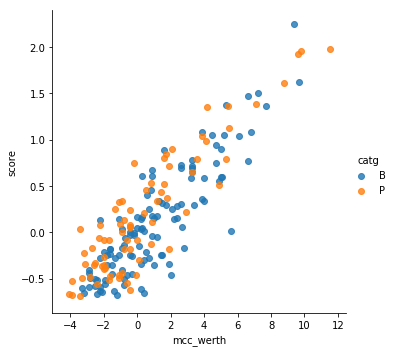

In [140]:
sb.lmplot(x="mcc_werth", y="score", hue="catg", fit_reg=False, data=dfd[dfd['rank'] < 200.0])